Група A (контрольна група):
Колір фону — білий (стандартний варіант).

Група B (експериментальна група):
Колір фону — чорний (нова версія для тестування).

Основна мета:
Визначити, чи є значне покращення часу перебування на сайті у разі впровадження нового дизайну (чорний фон).

Опис колонок у наборі даних:  
**User ID**: Ідентифікатор користувача.  
**Group**: Належність до групи (A — контрольна, B — експериментальна).  
**Page Views**: Кількість переглянутих сторінок під час сесії користувача.  
**Time Spent**: Загальний час (у секундах), проведений користувачем на сайті під час сесії.  
**Conversion**: Чи виконав користувач бажану дію (так/ні), наприклад, покупку або реєстрацію.  
**Device**: Тип пристрою, з якого користувач зайшов на вебсайт.  
**Location**: Регіон Великої Британії, де знаходиться користувач.  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest, probplot, norm,mannwhitneyu, chi2_contingency,pointbiserialr, shapiro

In [3]:
df = pd.read_csv('ab_testing.csv')
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.shape

(5000, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user id     5000 non-null   int64 
 1   group       5000 non-null   object
 2   page views  5000 non-null   int64 
 3   time spent  5000 non-null   int64 
 4   conversion  5000 non-null   object
 5   device      5000 non-null   object
 6   location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [7]:
df.isnull().sum()

user id       0
group         0
page views    0
time spent    0
conversion    0
device        0
location      0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
users_a = set(df[df['group'] == 'A']['user id'])
users_b = set(df[df['group'] == 'B']['user id'])
overlap_users = users_a.intersection(users_b)

print(overlap_users)

set()


In [10]:
quantity_a = df[df['group'] == 'A']['user id'].count()
quantity_b = df[df['group'] == 'B']['user id'].count()
print(f'Кількість користувачів в контрольній групі {quantity_a} '
      f'та в експерементальній групі {quantity_b}')

Кількість користувачів в контрольній групі 2519 та в експерементальній групі 2481


In [11]:
df.groupby('group')[['time spent']].describe()

time spent                                                          
           count        mean         std   min    25%    50%    75%    max
group                                                                     
A         2519.0  241.733227  117.340026  40.0  137.5  241.0  343.0  449.0
B         2481.0  243.303910  119.193552  40.0  136.0  244.0  348.0  449.0

Середнє значення та медіана показника time spent мають наближені значення в обох групах, що свідчить про відсутність викидів та аномалій у даних.
Майже однакові значення всіх мір центральної тенденції вказують на схожий розподіл даних, що знижує ймовірність наявності статистично значущих відмінностей між групами.

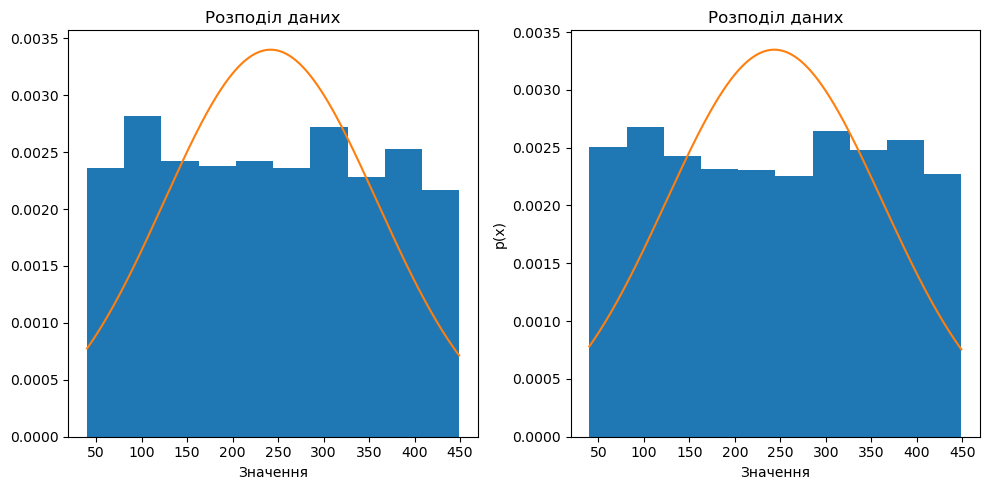

In [14]:
group_a = df[df['group'] == 'A']['time spent']
group_b = df[df['group'] == 'B']['time spent']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
mean_a = np.mean(group_a)
std_dev_a = np.std(group_a)
x_axis_a = np.arange(group_a.min(), group_a.max(), 0.01)
plt.hist(group_a, density=True)
plt.plot(x_axis_a, norm.pdf(x_axis_a, mean_a, std_dev_a))
plt.title('Розподіл даних')
plt.xlabel('Значення')

plt.subplot(1,2,2)
mean_b= np.mean(group_b)
std_dev_b = np.std(group_b)
x_axis_b = np.arange(group_b.min(), group_b.max(), 0.01)
plt.hist(group_b, density=True)
plt.plot(x_axis_b, norm.pdf(x_axis_b, mean_b, std_dev_b))
plt.title('Розподіл даних')
plt.xlabel('Значення')
plt.ylabel('p(x)')

plt.tight_layout()
plt.show();

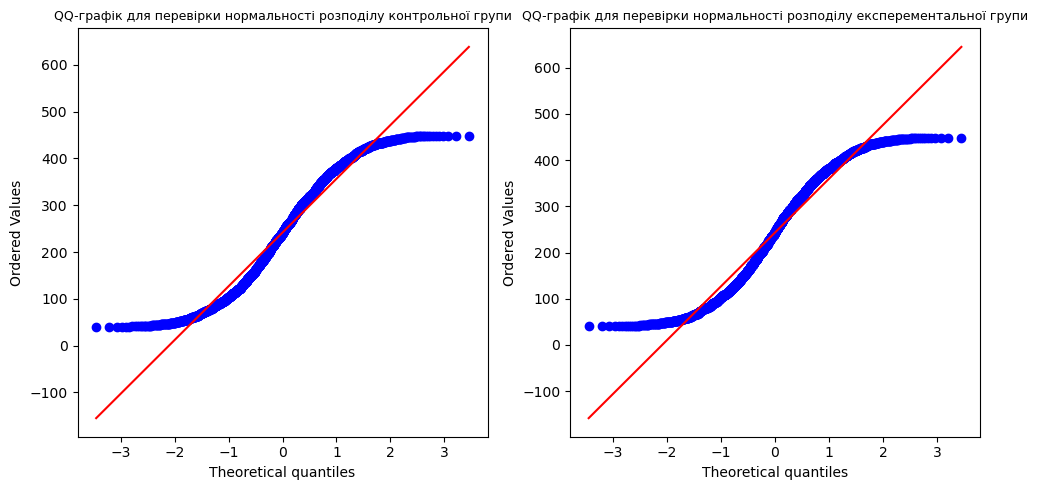

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
probplot(group_a, dist='norm', plot=plt)
plt.title("QQ-графік для перевірки нормальності розподілу контрольної групи", fontsize=9)

plt.subplot(1,2,2)
probplot(group_b, dist='norm', plot=plt)
plt.title("QQ-графік для перевірки нормальності розподілу експерементальної групи", fontsize=9)

plt.tight_layout()
plt.show();

Аналіз двох графіків свідчить, що дані в обох групах мають ненормальний і рівномірний розподіл.
Для підтвердження цього твердження використаємо статистичний тест Шапіро-Вілка, оскільки досліджувані вибірки містять менше ніж 5000 спостережень. 

In [67]:
state_a, p_value_a = shapiro(group_a)
state_b, p_value_b = shapiro(group_b)

if p_value_a > 0.05:
    print(f'Розподіл в контрольній групі є нормальним (p-value={p_value_a:.2f})')
else:
    print(f'Розподіл в контрольній групі є ненормальним (p-value={p_value_a:.2f})')

if p_value_b > 0.05:
    print(f'Розподіл у експериментальній групі є нормальним (p-value={p_value_b:.2f})')
else:
    print(f'Розподіл у експериментальній групі є ненормальним (p-value={p_value_b:.2f})')

Розподіл в контрольній групі є ненормальним (p-value=0.00)
Розподіл у експериментальній групі є ненормальним (p-value=0.00)


Гіпотези для A/B-тесту:  
H0=Користувачі проводять однакову кількість часу на сайті незалежно від кольору фону (білий чи чорний).    
H1=Користувачі проводять різну кількість часу на сайті залежно від кольору фону.   
   
Для перевірки гіпотез буде використано непараметричний тест Mann-Whitney U, оскільки вибірки мають нерівномірний розподіл даних.

In [76]:
stat, p_value = mannwhitneyu(group_a,group_b)

if p_value > 0.05:
    print(f'Колір фону не впливає на кількість часy, проведеного на сайті (stat={stat:.3f}, p-value={p_value:.3f})')
else:
    print(f'Колір фону впливає на кількість часу, проведеного на сайті (stat={stat:.3f}, p-value={p_value:.3f})')

Колір фону не впливає на кількість часy, проведеного на сайті (stat=3101095.000, p-value=0.642)


Перевіримо вибірку на приховану упередженість, що висновки для підгруп (по девайсам та локаціям) узгоджуються з загальними результатами для всього набору даних.

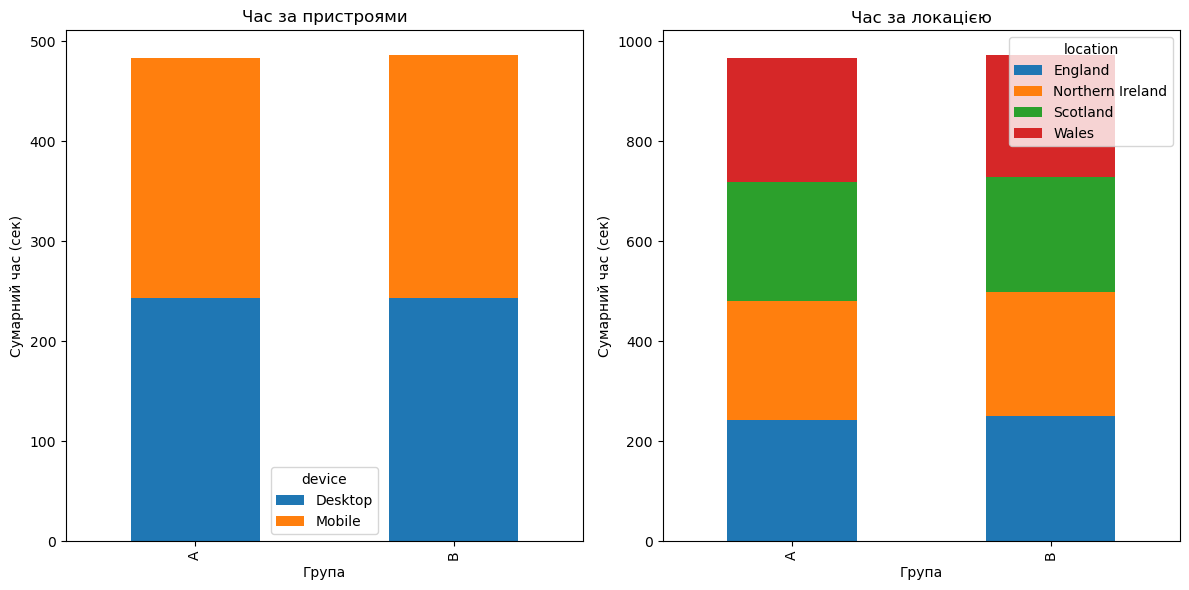

In [27]:
device_time = df.groupby(['group', 'device'])['time spent'].mean().unstack()
location_time = df.groupby(['group', 'location'])['time spent'].mean().unstack()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)                       
device_time.plot(kind='bar', stacked=True, ax=plt.gca()) 
plt.title('Час за пристроями')
plt.xlabel('Група')
plt.ylabel('Сумарний час (сек)')


plt.subplot(1, 2, 2)                      
location_time.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Час за локацією')
plt.xlabel('Група')
plt.ylabel('Сумарний час (сек)')


plt.tight_layout()
plt.show();

Після аналізу графіків для підгруп за пристроями (Mobile, Desktop) та локаціями (регіони Великої Британії) було виявлено, що розподіл часу, проведеного на сайті, у контрольній (Group A) та експериментальній групі (Group B) залишається подібним до загальної вибірки.
Для підтвердження, чи є статистично значущі результати залежно від пристрою та локації, буде проведено відповідний статистичний тест.

In [58]:
def stat_test (df, category):
    grouped_data = df.groupby(['group', category])['time spent']
    categories = df[category].unique()

    for cat in categories:
        group_A = grouped_data.get_group(('A', cat))
        group_B = grouped_data.get_group(('B', cat))
        stat, p_value = mannwhitneyu(group_A, group_B)
        if p_value>0.05:
            print(f'Для категорії {cat} колір фону не впливає на час проведення на сайті stat={stat:.3f}, p_value={p_value:.3f}')
        else:
            print(f'Для категорії {cat} колір фону впливає на час проведення на сайті stat={stat:.3f}, p_value={p_value:.3f}')

stat_test(df,'device')
stat_test(df,'location')

Для категорії Mobile колір фону не впливає на час проведення на сайті stat=746300.500, p_value=0.555
Для категорії Desktop колір фону не впливає на час проведення на сайті stat=803848.500, p_value=0.956
Для категорії Northern Ireland колір фону не впливає на час проведення на сайті stat=184633.000, p_value=0.197
Для категорії Scotland колір фону не впливає на час проведення на сайті stat=212586.500, p_value=0.232
Для категорії Wales колір фону не впливає на час проведення на сайті stat=192394.500, p_value=0.623
Для категорії England колір фону не впливає на час проведення на сайті stat=186126.500, p_value=0.220


Згідно з результатами тесту Mann-Whitney U, отримане p-value не вказує на наявність статистично значущих відмінностей у розподілі часу, проведеного на сайті, між підгрупами за пристроями та локаціями у контрольній та експериментальній групах.

Проаналізуємо конверсію для двух груп.

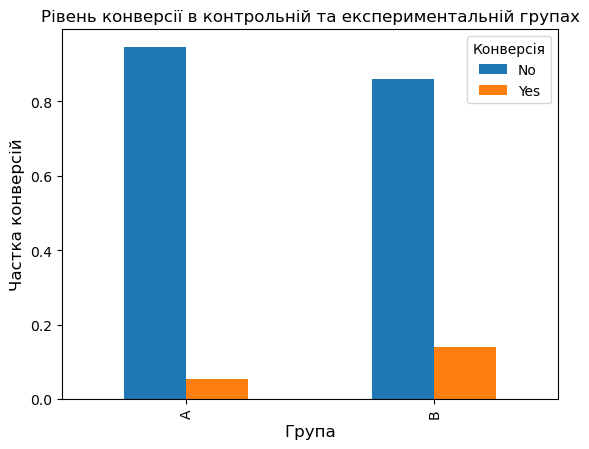

In [87]:
group_conversion = df.groupby('group')['conversion'].value_counts(normalize=True).unstack()

group_conversion.plot.bar()
plt.title('Рівень конверсії в контрольній та експериментальній групах')
plt.xlabel('Група', fontsize=12)
plt.ylabel('Частка конверсій', fontsize=12)
plt.legend(title='Конверсія')
plt.show();

Аналізуючи графік рівня конверсії у контрольній та експериментальній групах, бачимо, що рівень конверсії в експериментальній групі значно вищий: 5,4% проти 14,1%.  
Для визначення статистичної значущості цієї різниці буде проведено хі-квадрат (Chi²) тест, оскільки конверсія є біноміальною категоріальною змінною.   
Гіпотези для тесту:  
H0: Рівень конверсії не залежить від кольору фону на сайті (білий чи чорний).  
H1: Рівень конверсії залежить від кольору фону на сайті (білий чи чорний).   

In [93]:
contingency_table = pd.crosstab(df['group'], df['conversion'])

statistic_1, pvalue_1,dof,expected_freq=chi2_contingency(contingency_table)
print(f"Chi2 statistic: {statistic_1:.2f}")
print(f"P-value: {pvalue_1:.2f}")
if pvalue_1>0.05:
    print('Рівень конверсії не залежить від кольору фону')
else: 
    print('Рівень конверсії залежить від кольору фону')

Chi2 statistic: 106.23
P-value: 0.00
Рівень конверсії залежить від кольору фону


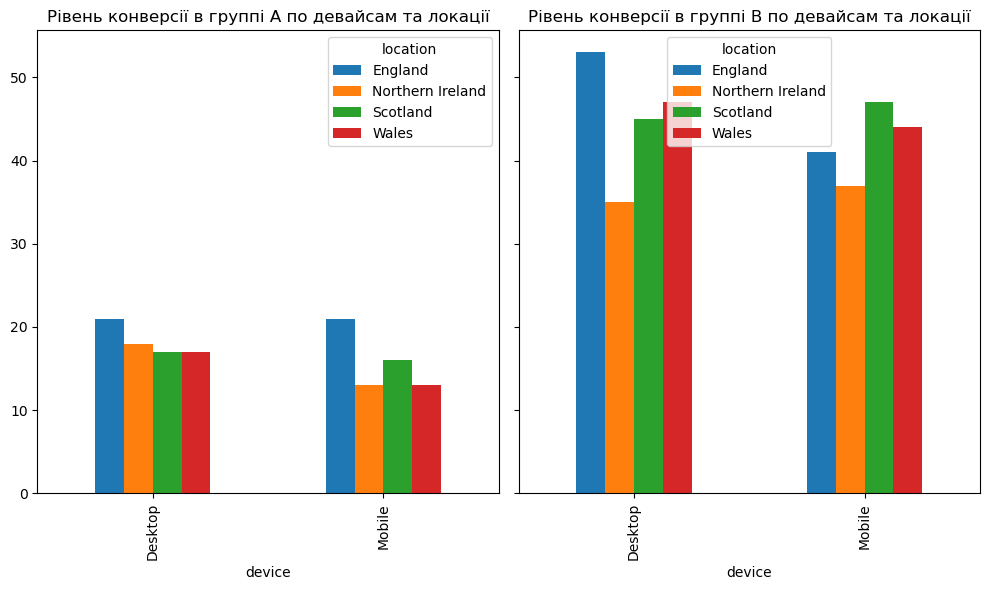

In [35]:
#Дослідження рівня конверсії по групам пристороїв та локації

df['conversion_binary'] = np.where(df['conversion'] == 'Yes', 1, 0)
group_a_conversion = df[df['group']== 'A'].groupby(['device','location'])['conversion_binary'].sum().unstack()
group_b_conversion = df[df['group']== 'B'].groupby(['device','location'])['conversion_binary'].sum().unstack()

fig, axes=plt.subplots(1,2, figsize=(10,6), sharey=True)
group_a_conversion.plot.bar(ax=axes[0])
axes[0].set_title('Рівень конверсії в групі A за девайсами та локацією')

group_b_conversion.plot.bar(ax=axes[1])
axes[1].set_title('Рівень конверсії в групі B за девайсами та локацією')

plt.tight_layout()
plt.show();

У групі A спостерігається схожий рівень конверсії для Desktop і Mobile незалежно від локації. Однак у групі B рівень конверсії для Desktop суттєво вищий, ніж для Mobile у локації England, тоді як в інших локаціях рівень конверсії залишається на подібному рівні для обох девайсів.    


Проведу статистичний тест chi x2(всі дані в цьому аналізі мають категоріальний тип) для виявлення чи впливає пристрій та локація на рівень конверсії.  
H0=пристрій та локація не впливають на рівень конверсії  
H1=пристрій та локація впливають на рівень конверсії  

In [97]:
def chix2test (df, category):
    categories = df[category].unique()

    for cat in categories:
        filtered_df=df[df[category] == cat]
        contingency_table = pd.crosstab(filtered_df['group'], filtered_df['conversion'])
        statistic_1, pvalue_1,dof,expected_freq=chi2_contingency(contingency_table)
        if pvalue_1 > 0.05:
            print(f'Для категорії {cat} колір фону не впливає на рівень конверсії (stat = {statistic_1:.2f}, p-value = {pvalue_1:.2f})')
        else:
            print(f'Для категорії {cat} колір фону впливає на рівень конверсії (stat = {statistic_1:.2f}, p-value = {pvalue_1:.2f})')
            
chix2test(df, 'device')
chix2test(df, 'location')

Для категорії Mobile колір фону впливає на рівень конверсії (stat = 61.16, p-value = 0.00)
Для категорії Desktop колір фону впливає на рівень конверсії (stat = 44.82, p-value = 0.00)
Для категорії Northern Ireland колір фону впливає на рівень конверсії (stat = 15.97, p-value = 0.00)
Для категорії Scotland колір фону впливає на рівень конверсії (stat = 36.11, p-value = 0.00)
Для категорії Wales колір фону впливає на рівень конверсії (stat = 36.00, p-value = 0.00)
Для категорії England колір фону впливає на рівень конверсії (stat = 18.47, p-value = 0.00)


Використаю коефіцієнт кореляції Пойнт-Бісеріала (Point-Biserial Correlation Coefficient) для вимірювання кореляції між змінною conversion (категоріальна змінна) та time spent (неперервна числова змінна).

In [41]:
corr, p_value = pointbiserialr(df['conversion_binary'], df['time spent'])

print(f'Point-Biserial Correlation Coefficient: {corr:.2f}, p-value: {p_value:.2f}')

Point-Biserial Correlation Coefficient: 0.00, p-value: 0.88


Основною метою проведеного A/B-тесту було виявлення різниці у часі, проведеному на сайті, залежно від кольору фону.  
Однак під час аналізу даних був виявлений важливий прихований інсайт:  

Колір фону сайту впливає на рівень конверсії.  
Це свідчить про те, що дослідження лише часу, проведеного на сайті, не є достатньо корисною метрикою для оцінки ефективності дизайну.  
Аналіз показав, що існує дуже слабкий рівень кореляції між збільшенням часу перебування на сайті та рівнем конверсії.  
Надалі слід сфокусуватися на ключових метриках, таких як рівень конверсії, для подальших тестів.  